## Import statements

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from IPython.display import display

## Useful functions

In [13]:
def normalize_datetime(df, colname):
    df = df.rename(columns={colname: 'datetime'})
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
    return df

## Data preparation

### 1. Day ahead prices

In [14]:
day_ahead = pd.read_csv('DayAheadPrices/DayAheadPrices_DK1_202401010000-202501010000.csv')

day_ahead['MTU (UTC)'] = day_ahead['MTU (UTC)'].str.split(' - ').str[1]
day_ahead['MTU (UTC)'] = pd.to_datetime(day_ahead['MTU (UTC)'], format='%d/%m/%Y %H:%M:%S', utc=True)
display(day_ahead)

,MTU (UTC),Area,Sequence,Day-ahead Price (EUR/MWh),Intraday Period (UTC),Intraday Price (EUR/MWh)
0,2024-01-01 00:00:00+00:00,BZN|DK1,Without Sequence,16.99,NaN,NaN
1,2024-01-01 01:00:00+00:00,BZN|DK1,Without Sequence,28.14,NaN,NaN
2,2024-01-01 02:00:00+00:00,BZN|DK1,Without Sequence,26.66,NaN,NaN
3,2024-01-01 03:00:00+00:00,BZN|DK1,Without Sequence,4.14,NaN,NaN
4,2024-01-01 04:00:00+00:00,BZN|DK1,Without Sequence,-0.03,NaN,NaN
...,...,...,...,...,...,...
8779,2024-12-31 19:00:00+00:00,BZN|DK1,Without Sequence,25.02,NaN,NaN
8780,2024-12-31 20:00:00+00:00,BZN|DK1,Without Sequence,19.00,NaN,NaN
8781,2024-12-31 21:00:00+00:00,BZN|DK1,Without Sequence,15.70,NaN,NaN
8782,2024-12-31 22:00:00+00:00,BZN|DK1,Without Sequence,9.06,NaN,NaN


### 2. Consumption

In [22]:
with zipfile.ZipFile('2024_Consumption.zip') as z:
    # Get the first (and only) file inside the zip
    file_name = z.namelist()[0]

    # Open the file inside the zip and read it with pandas
    with z.open(file_name) as f:
        consumption = pd.read_csv(f)

with open('region_muncipality.json') as f:
    region_to_dk = json.load(f)

consumption['Area'] = consumption['RegionName'].map(region_to_dk)
consumption['TimeUTC'] = pd.to_datetime(consumption['TimeUTC'], format='%Y-%m-%dT%H:%M:%S')
consumption['TimeUTC'] = consumption['TimeUTC'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
consumption_area = (
    consumption.groupby(["TimeUTC", "Area"])["ConsumptionkWh"]
    .sum()
    .reset_index()
)

display(consumption)

,TimeUTC,TimeDK,MunicipalityCode,Municipality,RegionName,HousingCategory,HeatingCategory,ConsumptionkWh,Area
0,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Parcel- og rækkehuse,Elvarme eller varmepumpe,5053.475,BZN|DK1
1,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Parcel- og rækkehuse,Andet,7957.491,BZN|DK1
2,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Fritidshuse,Elvarme eller varmepumpe,3813.127,BZN|DK1
3,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Fritidshuse,Andet,218.168,BZN|DK1
4,2023-12-31T23:00:00Z,2024-01-01T00:00:00,860,Hjørring,Region Nordjylland,Etageejendom,Elvarme eller varmepumpe,89.426,BZN|DK1
...,...,...,...,...,...,...,...,...,...
5699726,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Fritidshuse,Andet,178.665,BZN|DK2
5699727,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Etageejendom,Elvarme eller varmepumpe,514.990,BZN|DK2
5699728,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Etageejendom,Andet,42063.577,BZN|DK2
5699729,2024-12-31T22:00:00Z,2024-12-31T23:00:00,101,København,Region Hovedstaden,Andet,Elvarme eller varmepumpe,30.190,BZN|DK2


### 3. Sunlight

In [16]:
sunlight = pd.read_csv('weather/all_danish_hourly_sunlight_2024 formatted.csv', delimiter=';')
sunlight['datetime'] = pd.to_datetime(
    sunlight['date'] + ' ' + sunlight['to_time'],
    format='%Y-%m-%d %H:%M'  # matches your input
)

# Force timezone UTC
sunlight['datetime'] = sunlight['datetime'].dt.tz_localize('UTC')

# Convert to ISO 8601 with Z suffix
sunlight['datetime'] = sunlight['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

display(sunlight)

,date,station_id,station_name,to_time,sunshine_minutes,latitude,longitude,datetime
0,2024-01-04,6141,Abed,16:00,4.5,54.8275,11.3292,2024-01-04T16:00:00Z
1,2024-01-05,6141,Abed,10:00,2.0,54.8275,11.3292,2024-01-05T10:00:00Z
2,2024-01-05,6141,Abed,11:00,27.0,54.8275,11.3292,2024-01-05T11:00:00Z
3,2024-01-05,6141,Abed,12:00,19.0,54.8275,11.3292,2024-01-05T12:00:00Z
4,2024-01-05,6141,Abed,13:00,29.0,54.8275,11.3292,2024-01-05T13:00:00Z
...,...,...,...,...,...,...,...,...
86153,2024-12-22,6136,Tystofte,16:00,11.5,55.2465,11.3285,2024-12-22T16:00:00Z
86154,2024-12-24,6136,Tystofte,10:00,22.0,55.2465,11.3285,2024-12-24T10:00:00Z
86155,2024-12-24,6136,Tystofte,11:00,22.5,55.2465,11.3285,2024-12-24T11:00:00Z
86156,2024-12-24,6136,Tystofte,14:00,33.0,55.2465,11.3285,2024-12-24T14:00:00Z


### 4. Wind

In [17]:
wind = pd.read_csv('weather/danish_hourly_wind_data_2024.csv', delimiter=';')
wind['datetime'] = pd.to_datetime(
    wind['date'] + ' ' + wind['to_time'],
    format='%Y-%m-%d %H:%M'  # matches your input
)

# Force timezone UTC
wind['datetime'] = wind['datetime'].dt.tz_localize('UTC')

# Convert to ISO 8601 with Z suffix
wind['datetime'] = wind['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
display(wind)

,date,hour,from_time,to_time,station_id,station_name,parameter,value,latitude,longitude,datetime
0,2024-01-01,1,01:00,02:00,6019,Silstrup,max_wind_speed_10min,6.1,56.9300,8.6412,2024-01-01T02:00:00Z
1,2024-01-01,1,01:00,02:00,6019,Silstrup,max_wind_speed_3sec,8.1,56.9300,8.6412,2024-01-01T02:00:00Z
2,2024-01-01,1,01:00,02:00,6019,Silstrup,mean_wind_speed,5.5,56.9300,8.6412,2024-01-01T02:00:00Z
3,2024-01-01,2,02:00,03:00,6019,Silstrup,max_wind_speed_10min,5.3,56.9300,8.6412,2024-01-01T03:00:00Z
4,2024-01-01,2,02:00,03:00,6019,Silstrup,max_wind_speed_3sec,6.9,56.9300,8.6412,2024-01-01T03:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...
688603,2025-01-01,0,00:00,01:00,6193,Hammer Odde Fyr,max_wind_speed_3sec,24.0,55.2979,14.7718,2025-01-01T01:00:00Z
688604,2025-01-01,0,00:00,01:00,6193,Hammer Odde Fyr,mean_wind_speed,16.2,55.2979,14.7718,2025-01-01T01:00:00Z
688605,2025-01-01,0,00:00,01:00,6197,Nexø Vest,max_wind_speed_10min,12.7,55.0557,15.0953,2025-01-01T01:00:00Z
688606,2025-01-01,0,00:00,01:00,6197,Nexø Vest,max_wind_speed_3sec,18.9,55.0557,15.0953,2025-01-01T01:00:00Z


## Data Analysis

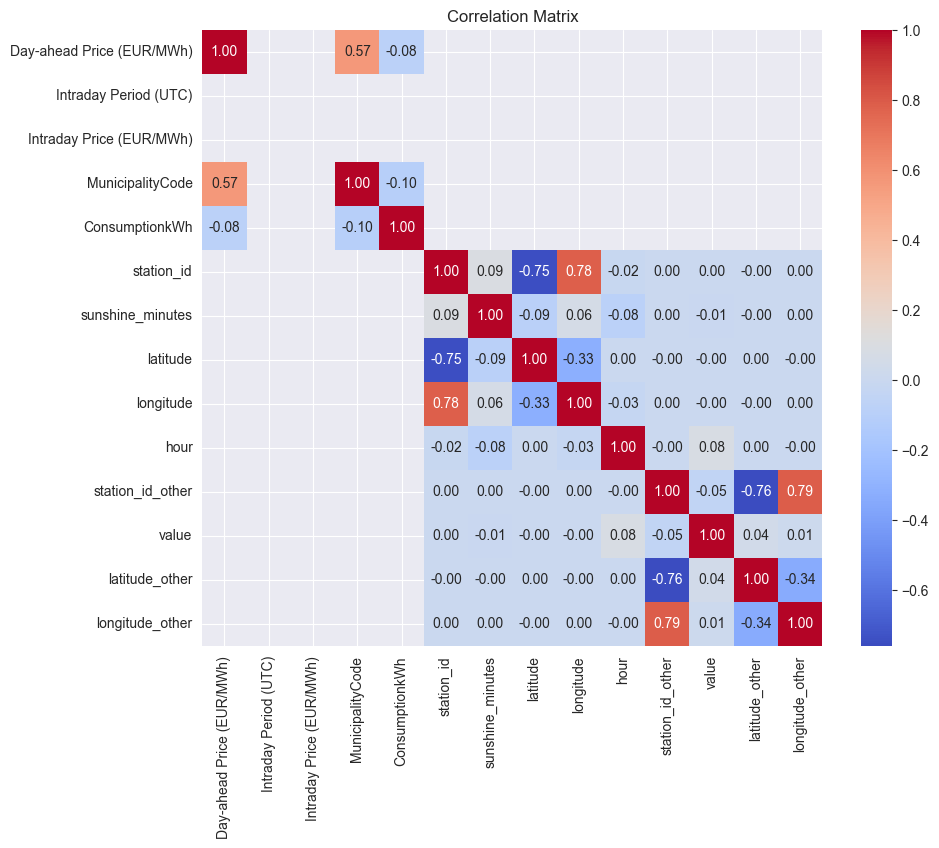

In [18]:
day_ahead = normalize_datetime(day_ahead, 'MTU (UTC)')
consumption = normalize_datetime(consumption, 'TimeUTC')

dfs = [day_ahead, consumption, sunlight, wind]

merged = dfs[0].set_index('datetime')
for dataframe in dfs[1:]:
    merged = merged.join(dataframe.set_index('datetime'), how='outer', rsuffix='_other')

merged.index = pd.to_datetime(merged.index, utc=True)


# Fill missing data if needed (forward fill is common for time series)
merged = merged.ffill()

# Calculate correlation matrix
correlation_matrix = merged.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()